In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import os
import sys
import torch
from torch.utils.data import DataLoader, Dataset


sys.path.append(os.path.abspath('../src'))
project_dir = Path.cwd().parent

from data_tools.data_utils import SeroDataset, PartialCountDataset, TrueCountDataset
from model_tools.train_utils import BaseTrain, SparsePropTrain
from model_tools.models import NowcastPNN, PropPNN, SparsePropPNN
from model_tools.evaluation import eval_pnn, eval_prop_pnn, eval_sparse_prop_pnn, plot_pnn_preds, plot_prop_pnn_preds
D = 40
M = 50
T = 10

start_year = 2013
end_year = 2023
data_split = [0.7, 0.15, 0.15]
seed = 123


In [2]:
# Create serotype obj
denv_df = pd.read_csv(project_dir / "data" / "transformed" / "denv_df.csv")
sero_props = pd.read_csv(project_dir / "data" / "transformed" / "sero_props.csv")

denv_df['Collection date'] = pd.to_datetime(denv_df['Collection date']).dt.to_period('M')
denv_df['Submission date'] = pd.to_datetime(denv_df['Submission date']).dt.to_period('M')
sero_props['Collection date'] = pd.to_datetime(sero_props['Collection date']).dt.to_period('M')
sero_dataset = SeroDataset(dataset=denv_df, prop_dataset=sero_props, T=T)

In [3]:
# Create count obj
delays_df = pd.read_csv(project_dir / "data" / "transformed" / "DENG_delays.csv")
delays_df['Collection date'] = pd.to_datetime(delays_df['Collection date'])

partial_count_dataset = PartialCountDataset(delays_df, D=D, M=M)
true_count_dataset = TrueCountDataset(delays_df)


In [7]:
dates = list(pd.date_range(f"{start_year}-01-01",f"{end_year}-12-25", freq='D'))
data_split_sizes = (np.array(data_split) * len(dates)).astype(int)

# Ensure dates line up fully, also removing 2023-12-31 as doesn't appear complete
data_split_sizes[-1] = len(dates) - data_split_sizes[:-1].sum()


train_dates = dates[:data_split_sizes[0]]
val_dates = dates[data_split_sizes[0]:data_split_sizes[0]+data_split_sizes[1]]
test_dates = dates[data_split_sizes[0]+data_split_sizes[1]:]


In [8]:
class PNNDataset(Dataset):
    def __init__(self, partial_count_obj, true_count_obj, dates):
        self.partial_count_obj = partial_count_obj
        self.true_count_obj = true_count_obj
        self.dates = dates
    
    def __len__(self):
        return len(self.dates)
    
    def __getitem__(self, index):
        date = self.dates[index]
        obs = self.partial_count_obj.get_obs(date)
        y = self.true_count_obj.get_y(date)
        dow = date.day_of_week
        return (obs, dow), y
    
train_pnn_dataset = PNNDataset(partial_count_dataset, true_count_dataset, train_dates)
val_pnn_dataset = PNNDataset(partial_count_dataset, true_count_dataset, val_dates)
test_pnn_dataset = PNNDataset(partial_count_dataset, true_count_dataset, test_dates)

g = torch.Generator()
g.manual_seed(seed)

train_loader = DataLoader(train_pnn_dataset, batch_size=32, shuffle=True, generator=g)
val_loader = DataLoader(val_pnn_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_pnn_dataset, batch_size=32, shuffle=False)


In [6]:
# pnn_model = NowcastPNN(M=M, D=D, hidden_units = [16, 8], conv_channels = [16, 1], embedding_dim = 10, dropout_probs = [0.15, 0.1], device="cpu")
# pnn_train = BaseTrain("PNN")
# pnn_train.train_model(pnn_model, train_loader, val_loader)

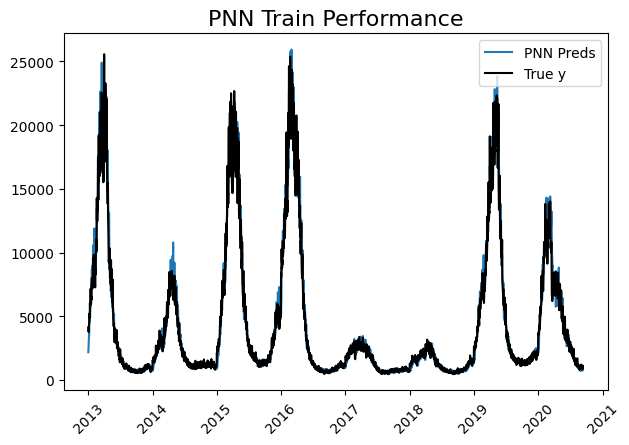

In [14]:
pnn_model = NowcastPNN(M=M, D=D, hidden_units = [16, 8], conv_channels = [16, 1], embedding_dim = 10, dropout_probs = [0.15, 0.1], device="cpu")
pnn_model.load_state_dict(torch.load(project_dir /"src" / "outputs" / "weights" / f"weights-PNN"))

pnn_train_samples = eval_pnn(train_pnn_dataset, pnn_model)
plot_pnn_preds(pnn_train_samples,train_pnn_dataset, "PNN Train Performance")

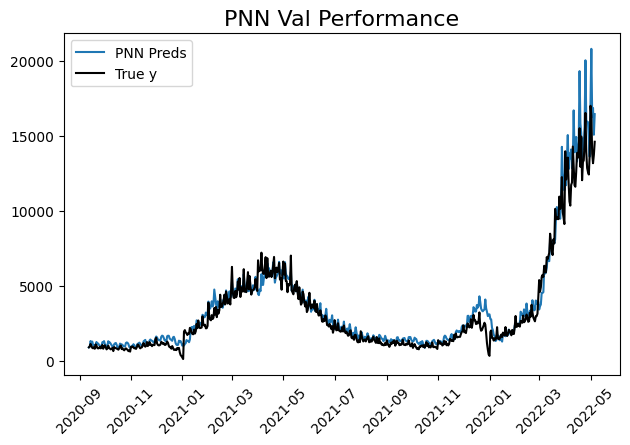

In [15]:
pnn_val_samples = eval_pnn(val_pnn_dataset, pnn_model)
plot_pnn_preds(pnn_val_samples,val_pnn_dataset, "PNN Val Performance")

In [12]:
pnn_test_samples = eval_pnn(test_pnn_dataset, pnn_model)
plot_pnn_preds(pnn_test_samples,test_pnn_dataset, "PNN Test Performance")

NameError: name 'pnn_model' is not defined

In [9]:
class PropPNNDataset(Dataset):
    def __init__(self, partial_count_obj, true_count_obj, dates):
        self.partial_count_obj = partial_count_obj
        self.true_count_obj = true_count_obj
        self.dates = dates
    
    def __len__(self):
        return len(self.dates)
    
    def __getitem__(self, index):
        date = self.dates[index]
        obs = self.partial_count_obj.get_obs(date)
        z = self.true_count_obj.get_z(date)
        dow = date.day_of_week
        return (obs, dow), z
    
train_prop_pnn_dataset = PropPNNDataset(partial_count_dataset, true_count_dataset, train_dates)
val_prop_pnn_dataset = PropPNNDataset(partial_count_dataset, true_count_dataset, val_dates)
test_prop_pnn_dataset = PropPNNDataset(partial_count_dataset, true_count_dataset, test_dates)

g = torch.Generator()
g.manual_seed(seed)

train_loader = DataLoader(train_prop_pnn_dataset, batch_size=32, shuffle=True, generator=g)
val_loader = DataLoader(val_prop_pnn_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_prop_pnn_dataset, batch_size=32, shuffle=False)


In [11]:
prop_pnn_model = PropPNN(M=M, D=D, hidden_units = [16, 8], conv_channels = [16, 1], embedding_dim = 10, dropout_probs = [0.15, 0.1], device="cpu")
prop_pnn_train = BaseTrain("PropPNN")
prop_pnn_train.train_model(prop_pnn_model, train_loader, val_loader)

Epoch 1 - Train loss: 7.31e+03 - Val loss: 9.79e+04 - ES count: 0
Epoch 2 - Train loss: 4.66e+03 - Val loss: 4.8e+04 - ES count: 0
Epoch 3 - Train loss: 3.3e+03 - Val loss: 3.9e+04 - ES count: 0
Epoch 4 - Train loss: 2.77e+03 - Val loss: 3.21e+04 - ES count: 0
Epoch 5 - Train loss: 2.55e+03 - Val loss: 2.64e+04 - ES count: 0
Epoch 6 - Train loss: 2.37e+03 - Val loss: 2.57e+04 - ES count: 0
Epoch 7 - Train loss: 2.18e+03 - Val loss: 2.3e+04 - ES count: 0
Epoch 8 - Train loss: 1.97e+03 - Val loss: 2.05e+04 - ES count: 0
Epoch 9 - Train loss: 1.83e+03 - Val loss: 2.21e+04 - ES count: 1
Epoch 10 - Train loss: 1.83e+03 - Val loss: 1.92e+04 - ES count: 0
Epoch 11 - Train loss: 1.81e+03 - Val loss: 1.62e+04 - ES count: 0
Epoch 12 - Train loss: 1.64e+03 - Val loss: 2.03e+04 - ES count: 1
Epoch 13 - Train loss: 1.68e+03 - Val loss: 1.69e+04 - ES count: 2
Epoch 14 - Train loss: 1.59e+03 - Val loss: 1.4e+04 - ES count: 0
Epoch 15 - Train loss: 1.47e+03 - Val loss: 1.5e+04 - ES count: 1
Epoch 16 -

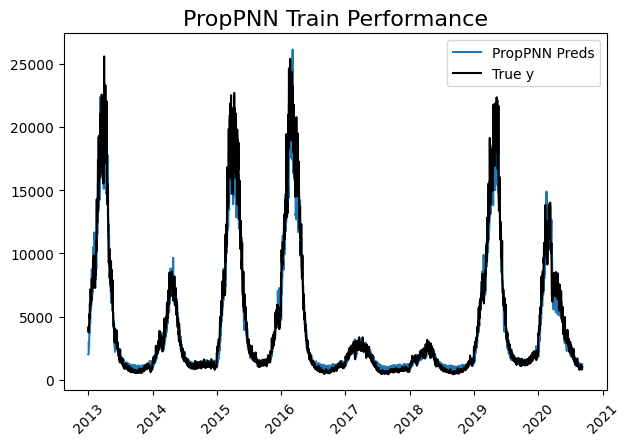

In [10]:
prop_pnn_model = PropPNN(M=M, D=D, hidden_units = [16, 8], conv_channels = [16, 1], embedding_dim = 10, dropout_probs = [0.15, 0.1], device="cpu")
prop_pnn_model.load_state_dict(torch.load(project_dir /"src" / "outputs" / "weights" / f"weights-PropPNN"))

prop_pnn_train_samples = eval_prop_pnn(train_prop_pnn_dataset, prop_pnn_model)
plot_prop_pnn_preds(prop_pnn_train_samples,train_prop_pnn_dataset, "PropPNN Train Performance")

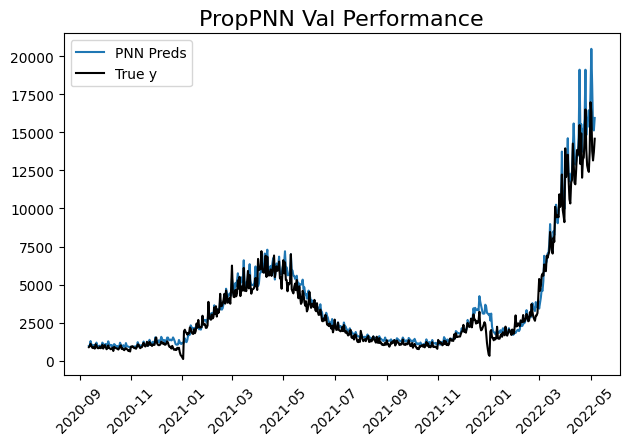

In [7]:
prop_pnn_val_samples = eval_prop_pnn(val_prop_pnn_dataset, prop_pnn_model)
plot_prop_pnn_preds(prop_pnn_val_samples,val_prop_pnn_dataset, "PropPNN Val Performance")

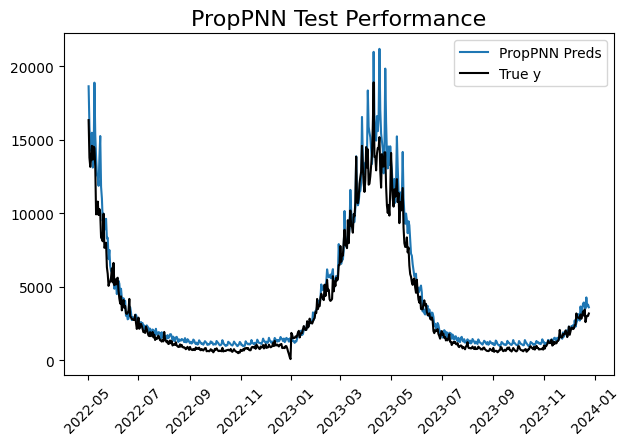

In [11]:
prop_pnn_test_samples = eval_prop_pnn(test_prop_pnn_dataset, prop_pnn_model)
plot_prop_pnn_preds(prop_pnn_test_samples,test_prop_pnn_dataset, "PropPNN Test Performance")

In [7]:
sparse_prop_pnn_model = SparsePropPNN(M=M, D=D, hidden_units = [16, 8], conv_channels = [16, 1], embedding_dim = 10, dropout_probs = [0.15, 0.1], device="cpu")
sparse_prop_pnn_train = SparsePropTrain("SparsePropPNN")
sparse_prop_pnn_train.train_model(sparse_prop_pnn_model, train_loader, val_loader)

Epoch 1 - Train loss: 2.42e+05 - Val loss: 3.39e+06 - ES count: 0
Epoch 2 - Train loss: 1.64e+05 - Val loss: 1.93e+06 - ES count: 0
Epoch 3 - Train loss: 1.23e+05 - Val loss: 1.53e+06 - ES count: 0
Epoch 4 - Train loss: 1.03e+05 - Val loss: 1.32e+06 - ES count: 0
Epoch 5 - Train loss: 9.19e+04 - Val loss: 1.04e+06 - ES count: 0
Epoch 6 - Train loss: 8.78e+04 - Val loss: 8.11e+05 - ES count: 0
Epoch 7 - Train loss: 8.01e+04 - Val loss: 8.23e+05 - ES count: 1
Epoch 8 - Train loss: 7.46e+04 - Val loss: 7.07e+05 - ES count: 0
Epoch 9 - Train loss: 7.28e+04 - Val loss: 7e+05 - ES count: 0
Epoch 10 - Train loss: 6.51e+04 - Val loss: 5.96e+05 - ES count: 0
Epoch 11 - Train loss: 6.15e+04 - Val loss: 6.13e+05 - ES count: 1
Epoch 12 - Train loss: 6.03e+04 - Val loss: 5.31e+05 - ES count: 0
Epoch 13 - Train loss: 5.76e+04 - Val loss: 5.84e+05 - ES count: 1
Epoch 14 - Train loss: 5.59e+04 - Val loss: 5.03e+05 - ES count: 0
Epoch 15 - Train loss: 5.12e+04 - Val loss: 4.6e+05 - ES count: 0
Epoch 16

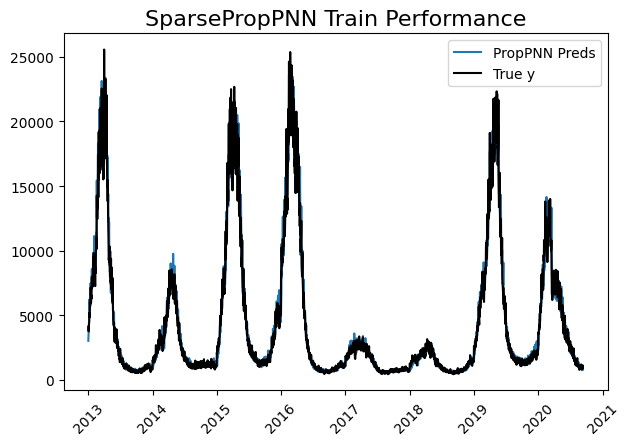

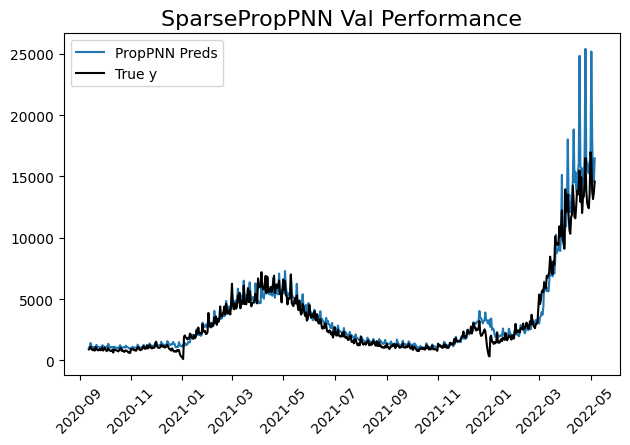

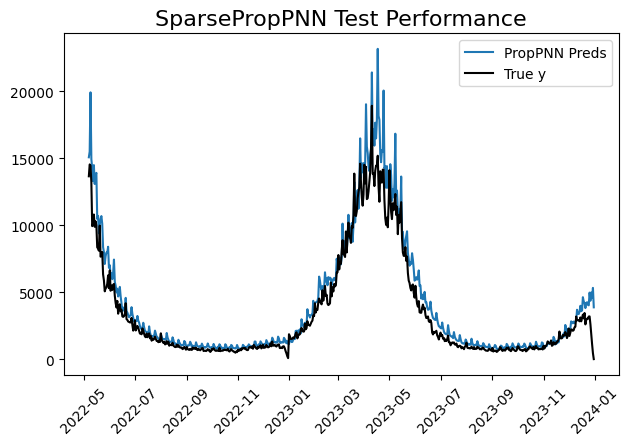

In [6]:
sparse_prop_pnn_model = SparsePropPNN(M=M, D=D, hidden_units = [16, 8], conv_channels = [16, 1], embedding_dim = 10, dropout_probs = [0.15, 0.1], device="cpu")
sparse_prop_pnn_model.load_state_dict(torch.load(project_dir /"src" / "outputs" / "weights" / f"weights-SparsePropPNN"))

sparse_prop_pnn_train_samples = eval_sparse_prop_pnn(train_prop_pnn_dataset, sparse_prop_pnn_model)
plot_prop_pnn_preds(sparse_prop_pnn_train_samples,train_prop_pnn_dataset, "SparsePropPNN Train Performance")

sparse_prop_pnn_val_samples = eval_sparse_prop_pnn(val_prop_pnn_dataset, sparse_prop_pnn_model)
plot_prop_pnn_preds(sparse_prop_pnn_val_samples,val_prop_pnn_dataset, "SparsePropPNN Val Performance")

sparse_prop_pnn_test_samples = eval_sparse_prop_pnn(test_prop_pnn_dataset, sparse_prop_pnn_model)
plot_prop_pnn_preds(sparse_prop_pnn_test_samples,test_prop_pnn_dataset, "SparsePropPNN Test Performance")